In [ ]:
!pip install transformers accelerate sentencepiece bitsandbytes

import json
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

# Your HF token
hf_token = "put your hf token"

# Specify the model ID for Meta-Llama-3-8B-Instruct
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)

# Configure for 8-bit quantization and low CPU memory usage
quant_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_auth_token=hf_token,
    quantization_config=quant_config,
    device_map="auto",
    low_cpu_mem_usage=True
)

# Create a text-generation pipeline without specifying device (Accelerate manages it)
gen_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)

def parse_floorplan(prompt_text):
    instructions="""You are an expert floor plan parser. Your task is to convert a free-form floor plan description into a valid JSON object with exactly the structure below. Do not output any additional text—only the JSON object, enclosed between the markers ###START### and ###END###.

Instructions:
1. The JSON object must include exactly these keys (in this order): "living_room", "bedroom1", "bedroom2", "kitchen", and "bathroom".
2. For each room, "width" and "height" must be integers representing dimensions in meters, as extracted from the description.
3. For the "living_room", include a boolean key "center" set to true.
4. The keys "north", "south", "east", and "west" should be either a string (indicating an adjacent room), an object (e.g., {"room_name": {"type": "door"}}), or null if not provided.
5. The "image" key must be a string representing the image path; use the image names from the description (assume a standard path prefix such as "/kaggle/input/your-dataset/name.png").
6. The "adjacency" key in "living_room" should be an empty object.
7. Do not provide any extra keys or commentary.
8. If any room is not mentioned or a dimension or image is missing, output null for that value.

Use the following JSON structure as your template:

###START###
{
  "living_room": {
    "width": <integer>,
    "height": <integer>,
    "center": true,
    "north": null,
    "south": null,
    "east": null,
    "west": null,
    "image": "<image_path>",
    "adjacency": {}
  },
  "bedroom1": {
    "width": <integer>,
    "height": <integer>,
    "north": "living_room",
    "south": null,
    "east": null,
    "west": {"living_room": {"type": "door"}},
    "image": "<image_path>"
  },
  "bedroom2": {
    "width": <integer>,
    "height": <integer>,
    "north": null,
    "south": {"living_room": {"type": "open"}},
    "east": null,
    "west": null,
    "image": "<image_path>"
  },
  "kitchen": {
    "width": <integer>,
    "height": <integer>,
    "north": null,
    "south": null,
    "east": {"living_room": {"type": "door"}},
    "west": null,
    "image": "<image_path>"
  },
  "bathroom": {
    "width": <integer>,
    "height": <integer>,
    "north": null,
    "south": null,
    "east": null,
    "west": {"bedroom1": {"type": "door"}},
    "image": "<image_path>"
  }
}
###END###

Now, convert the following free-form floor plan description into the JSON object exactly as above:

We have a kitchen that is 6m x 5m, next to the living room with an open boundary.
The living room is 10m x 5m, has a corridor above it with a door boundary.
Bedroom1 is 4m x 5m on the left side of the corridor, closed boundary.
Bedroom2 is 4m x 4m next to the corridor with a door.
Bedroom3 is 4m x 4m with a closed boundary to bedroom2 on top,
and also next to corridor with a door.
Ignore any extra lounge areas if mentioned.
"""


    output = gen_pipeline(instructions, max_new_tokens=1024, do_sample=True, temperature=0.3)[0]["generated_text"]
    return output

def extract_json(text):
    """
    Extracts the JSON object enclosed between ###START### and ###END###.
    """
    match = re.search(r'###START###(.*?)###END###', text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return text

# Test input: a free-form floor plan description
test_prompt_text = """
We have a kitchen that is 6m x 5m, next to the living room with an open boundary.
The living room is 10m x 5m, with a corridor above it that has a door boundary.
Bedroom1 is 4m x 5m on the left side of the corridor, and it has a closed boundary.
Bedroom2 is 4m x 4m, located next to the corridor with a door.
Bedroom3 is 4m x 4m, positioned above bedroom2 with a closed boundary, and also next to the corridor with a door.
The bathroom is 4m x 3m, placed near bedroom2.
"""

raw_output = parse_floorplan(test_prompt_text)
print("Raw model output:\n", raw_output)

json_text = extract_json(raw_output)
print("\nExtracted JSON text:\n", json_text)

try:
    parsed_json = json.loads(json_text)
    print("\nParsed JSON:\n", json.dumps(parsed_json, indent=2))
except Exception as e:
    print("\nError parsing JSON:", e)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:833: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Raw model output:
 You are an expert floor plan parser. Your task is to convert a free-form floor plan description into a valid JSON object with exactly the structure below. Do not output any additional text—only the JSON object, enclosed between the markers ###START### and ###END###.

Instructions:
1. The JSON object must include exactly these keys (in this order): "living_room", "bedroom1", "bedroom2", "kitchen", and "bathroom".
2. For each room, "width" and "height" must be integers representing dimensions in meters, as extracted from the description.
3. For the "living_room", include a boolean key "center" set to true.
4. The keys "north", "south", "east", and "west" should be either a string (indicating an adjacent room), an object (e.g., {"room_name": {"type": "door"}}), or null if not provided.
5. The "image" key must be a string representing the image path; use the image names from the description (assume a standard path prefix such as "/kaggle/input/your-dataset/name.png").
6.

In [2]:
import re
import json

# Assume raw_output is already defined with multiple JSON blocks
print("Full Output:\n", raw_output)

# Find all JSON blocks between the markers
json_blocks = re.findall(r'###START###(.*?)###END###', raw_output, re.DOTALL)
print("Found JSON blocks:", len(json_blocks))
for i, block in enumerate(json_blocks, 1):
    print(f"Block {i}:\n{block.strip()}\n")

# Extract only Block 3
if len(json_blocks) >= 3:
    block3_str = json_blocks[2].strip()
    try:
        block3_json = json.loads(block3_str)
        print("Extracted Block 3 JSON:")
        block_json=json.dumps(block3_json, indent=2)
        print(block_json)
    except json.JSONDecodeError as e:
        print("Error parsing Block 3 JSON:", e)
else:
    print("Less than 3 JSON blocks found.")


Full Output:
 You are an expert floor plan parser. Your task is to convert a free-form floor plan description into a valid JSON object with exactly the structure below. Do not output any additional text—only the JSON object, enclosed between the markers ###START### and ###END###.

Instructions:
1. The JSON object must include exactly these keys (in this order): "living_room", "bedroom1", "bedroom2", "kitchen", and "bathroom".
2. For each room, "width" and "height" must be integers representing dimensions in meters, as extracted from the description.
3. For the "living_room", include a boolean key "center" set to true.
4. The keys "north", "south", "east", and "west" should be either a string (indicating an adjacent room), an object (e.g., {"room_name": {"type": "door"}}), or null if not provided.
5. The "image" key must be a string representing the image path; use the image names from the description (assume a standard path prefix such as "/kaggle/input/your-dataset/name.png").
6. The 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print(block_json)


{
  "living_room": {
    "width": 10,
    "height": 5,
    "center": true,
    "north": null,
    "south": null,
    "east": null,
    "west": null,
    "image": "/kaggle/input/your-dataset/living_room.png",
    "adjacency": {}
  },
  "bedroom1": {
    "width": 4,
    "height": 5,
    "north": null,
    "south": null,
    "east": null,
    "west": {
      "living_room": {
        "type": "door"
      }
    },
    "image": "/kaggle/input/your-dataset/bedroom1.png"
  },
  "bedroom2": {
    "width": 4,
    "height": 4,
    "north": null,
    "south": {
      "living_room": {
        "type": "open"
      }
    },
    "east": null,
    "west": null,
    "image": "/kaggle/input/your-dataset/bedroom2.png"
  },
  "kitchen": {
    "width": 6,
    "height": 5,
    "north": null,
    "south": null,
    "east": {
      "living_room": {
        "type": "door"
      }
    },
    "west": null,
    "image": "/kaggle/input/your-dataset/kitchen.png"
  },
  "bathroom": {
    "width": 2,
    "height": 2,


In [5]:
import os

def list_images_in_dataset(dataset_folder="/kaggle/input/floor-planners"):
    """
    Lists all image files available in the Kaggle dataset folder.
    """
    if not os.path.exists(dataset_folder):
        print(f"Folder '{dataset_folder}' does not exist. Please add the dataset to your notebook.")
        return []

    image_files = []
    for root, dirs, files in os.walk(dataset_folder):
        for filename in files:
            # Optionally, filter for common image extensions
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                image_path = os.path.join(root, filename)
                image_files.append(image_path)
                print(image_path)
    return image_files

# Example usage:
image_paths = list_images_in_dataset("/kaggle/input/floor-planners")


Folder '/kaggle/input/floor-planners' does not exist. Please add the dataset to your notebook.


In [6]:
block_json = json.loads(block_json)

{'living_room': {'width': 10, 'height': 5, 'center': True, 'north': None, 'south': None, 'east': None, 'west': None, 'image': '/kaggle/input/your-dataset/living_room.png', 'adjacency': {}}, 'bedroom1': {'width': 4, 'height': 5, 'north': None, 'south': None, 'east': None, 'west': {'living_room': {'type': 'door'}}, 'image': '/kaggle/input/your-dataset/bedroom1.png'}, 'bedroom2': {'width': 4, 'height': 4, 'north': None, 'south': {'living_room': {'type': 'open'}}, 'east': None, 'west': None, 'image': '/kaggle/input/your-dataset/bedroom2.png'}, 'kitchen': {'width': 6, 'height': 5, 'north': None, 'south': None, 'east': {'living_room': {'type': 'door'}}, 'west': None, 'image': '/kaggle/input/your-dataset/kitchen.png'}, 'bathroom': {'width': 2, 'height': 2, 'north': None, 'south': None, 'east': None, 'west': {'bedroom3': {'type': 'door'}}, 'image': '/kaggle/input/your-dataset/bathroom.png'}}


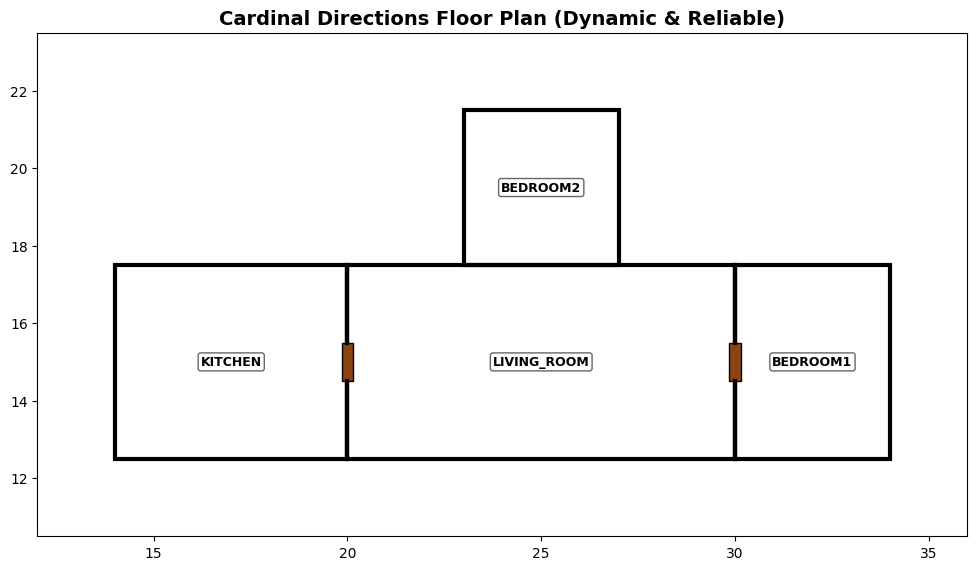

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import numpy as np
print(block_json)
########################################
# 1) ARRANGE ROOMS (Cardinal Directions)
########################################

def arrange_rooms_cardinal(rooms, bounding_box=(0,0,50,30)):
    """
    Places each room according to cardinal directions:
      - "center": True => place in bounding box center
      - "north", "south", "east", "west" => can be:
          1) None
          2) "some_room"
          3) { "some_room": {"type": "door"/"closed"/"open"} }

    This means:
      "north": "X" => top edge of this room = bottom edge of X
      "south": "X" => bottom edge of this room = top edge of X
      "east":  "X" => right edge of this room = left edge of X
      "west":  "X" => left edge of this room = right edge of X

    We store each room's coords in rooms[room]["coords"] = (x1,y1,x2,y2).
    """

    (bx1, by1, bx2, by2) = bounding_box
    w_box = bx2 - bx1
    h_box = by2 - by1

    # 1) Find center room
    center_room = None
    for rname, rdata in rooms.items():
        if rdata.get("center", False) == True:
            center_room = rname
            break
    if not center_room:
        # fallback if none marked center
        center_room = list(rooms.keys())[0]
        rooms[center_room]["center"] = True

    # 2) Place center in bounding box center
    cw = rooms[center_room]["width"]
    ch = rooms[center_room]["height"]
    cx1 = bx1 + (w_box - cw)/2
    cy1 = by1 + (h_box - ch)/2
    rooms[center_room]["coords"] = (cx1, cy1, cx1+cw, cy1+ch)

    placed = {center_room}
    changed = True
    # We'll loop until no changes or everything is placed
    while changed:
        changed = False
        for rname, rdata in rooms.items():
            if rname in placed:
                continue

            w = rdata["width"]
            h = rdata["height"]
            x1,y1,x2,y2 = None,None,None,None

            # parse cardinal directions
            n_info = parse_cardinal(rdata.get("north", None))
            s_info = parse_cardinal(rdata.get("south", None))
            e_info = parse_cardinal(rdata.get("east",  None))
            w_info = parse_cardinal(rdata.get("west",  None))

            def try_place(dir_key, info):
                """
                info = (target_room, adjacency_type)
                if adjacency_type is not None, store adjacency
                """
                if info[0] is None:
                    return False
                target = info[0]
                if target not in rooms or "coords" not in rooms[target]:
                    return False

                tx1,ty1,tx2,ty2 = rooms[target]["coords"]
                if dir_key=="north":
                    # top edge of current = bottom edge of target
                    new_y2 = ty1
                    new_y1 = new_y2 - h
                    new_x1 = (tx1+tx2 - w)/2
                    new_x2 = new_x1 + w
                    store_coords(rname, rooms, (new_x1,new_y1,new_x2,new_y2), target, info[1])
                    return True

                elif dir_key=="south":
                    # bottom edge of current = top edge of target
                    new_y1 = ty2
                    new_y2 = new_y1 + h
                    new_x1 = (tx1+tx2 - w)/2
                    new_x2 = new_x1 + w
                    store_coords(rname, rooms, (new_x1,new_y1,new_x2,new_y2), target, info[1])
                    return True

                elif dir_key=="east":
                    # right edge of current = left edge of target
                    new_x2 = tx1
                    new_x1 = new_x2 - w
                    new_y1 = (ty1+ty2 - h)/2
                    new_y2 = new_y1 + h
                    store_coords(rname, rooms, (new_x1,new_y1,new_x2,new_y2), target, info[1])
                    return True

                elif dir_key=="west":
                    # left edge of current = right edge of target
                    new_x1 = tx2
                    new_x2 = new_x1 + w
                    new_y1 = (ty1+ty2 - h)/2
                    new_y2 = new_y1 + h
                    store_coords(rname, rooms, (new_x1,new_y1,new_x2,new_y2), target, info[1])
                    return True

                return False

            directions_order = [
                ("north", n_info),
                ("south", s_info),
                ("east",  e_info),
                ("west",  w_info)
            ]
            for dir_key, dir_info in directions_order:
                if try_place(dir_key, dir_info):
                    placed.add(rname)
                    changed=True
                    break

    return rooms

def parse_cardinal(val):
    """
    val can be None, a string, or an object like {"kitchen": {"type":"door"}}
    Returns (room_name, adjacency_type) or (None,None)
    """
    if val is None:
        return (None,None)
    if isinstance(val, str):
        return (val, None)
    if isinstance(val, dict):
        for k,v in val.items():
            return (k, v.get("type", None))
    return (None,None)

def store_coords(rname, rooms, coords, target_room, adjacency_type):
    """
    Store coords in rooms[rname]["coords"] = coords.
    If adjacency_type is not None, ensure adjacency is declared on both sides.
    """
    rooms[rname]["coords"] = coords
    if adjacency_type is not None:
        if "adjacency" not in rooms[rname]:
            rooms[rname]["adjacency"]={}
        if "adjacency" not in rooms[target_room]:
            rooms[target_room]["adjacency"]={}
        rooms[rname]["adjacency"][target_room]={"type": adjacency_type}
        rooms[target_room]["adjacency"][rname]={"type": adjacency_type}

########################################
# 2) AUTO ADD DOORS IF LONE & SHARE BOUNDARY
########################################

def auto_add_doors_for_lone_rooms(rooms):
    rnames = list(rooms.keys())
    for i in range(len(rnames)):
        for j in range(i+1,len(rnames)):
            r1=rnames[i]
            r2=rnames[j]
            if "coords" not in rooms[r1] or "coords" not in rooms[r2]:
                continue
            if not physically_share_boundary(rooms[r1]["coords"], rooms[r2]["coords"]):
                continue

            if "adjacency" not in rooms[r1]:
                rooms[r1]["adjacency"]={}
            if "adjacency" not in rooms[r2]:
                rooms[r2]["adjacency"]={}

            if r2 in rooms[r1]["adjacency"] or r1 in rooms[r2]["adjacency"]:
                continue

            a1_count=len(rooms[r1]["adjacency"])
            a2_count=len(rooms[r2]["adjacency"])
            if a1_count<=1 and a2_count<=1:
                rooms[r1]["adjacency"][r2]={"type":"door"}
                rooms[r2]["adjacency"][r1]={"type":"door"}

def physically_share_boundary(c1,c2,eps=1e-9):
    x1_1,y1_1,x2_1,y2_1=c1
    x1_2,y1_2,x2_2,y2_2=c2
    # vertical
    if abs(x2_1 - x1_2)<eps:
        oy1=max(y1_1,y1_2)
        oy2=min(y2_1,y2_2)
        if oy2>oy1:return True
    elif abs(x1_1 - x2_2)<eps:
        oy1=max(y1_1,y1_2)
        oy2=min(y2_1,y2_2)
        if oy2>oy1:return True
    # horizontal
    if abs(y2_1 - y1_2)<eps:
        ox1=max(x1_1,x1_2)
        ox2=min(x2_1,x2_2)
        if ox2>ox1:return True
    elif abs(y1_1 - y2_2)<eps:
        ox1=max(x1_1,x1_2)
        ox2=min(x2_1,x2_2)
        if ox2>ox1:return True
    return False

########################################
# 3) DRAW PERFECT WALLS + DOOR RECTANGLES
########################################

def draw_perfect_walls_with_doors(rooms, door_thickness=0.3, door_length=1.0):
    """
    Draw each room with thick black walls.
    If adjacency is "door", place a brown rectangle bridging boundary.
    If "closed", thick line. If "open", skip line.
    Also: if "image" key in a room, scale that image to fill the bounding box.
    """
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title("Cardinal Directions Floor Plan (Dynamic & Reliable)", fontsize=14, fontweight='bold')

    # bounding
    minx,miny=999999,999999
    maxx,maxy=0,0
    for rname,rdata in rooms.items():
        if "coords" not in rdata:
            continue
        x1,y1,x2,y2 = rdata["coords"]
        minx=min(minx,x1,x2)
        miny=min(miny,y1,y2)
        maxx=max(maxx,x1,x2)
        maxy=max(maxy,y1,y2)

    adjacency_edges=[]

    # Step 1: Draw the images behind
    for rname,rdata in rooms.items():
        if "coords" not in rdata:
            continue
        x1,y1,x2,y2 = rdata["coords"]
        # If there's an image, scale it to fill the bounding box
        if "image" in rdata and rdata["image"] is not None:
            image_path = rdata["image"]
            if os.path.exists(image_path):
                img = mpimg.imread(image_path)
                ax.imshow(img, extent=(x1,x2,y1,y2), origin='lower', alpha=1.0)
            else:
                print(f"Warning: image file '{image_path}' not found for room '{rname}'")

        # adjacency edges
        if "adjacency" in rdata:
            for nbr, edata in rdata["adjacency"].items():
                adjacency_edges.append((rname,nbr,edata["type"]))

    # Step 2: Draw thick black rectangles for room boundaries
    # We do this after images so the walls appear on top
    for rname,rdata in rooms.items():
        if "coords" not in rdata:
            continue
        x1,y1,x2,y2 = rdata["coords"]
        w = x2 - x1
        h = y2 - y1
        rect=patches.Rectangle(
            (x1,y1), w,h,
            linewidth=3, edgecolor='black', facecolor='none', alpha=1.0
        )
        ax.add_patch(rect)

        # Label on top
        ax.text(
            x1+w/2, y1+h/2,
            rname.upper(),
            ha='center', va='center',
            fontsize=9, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2')
        )

    # Step 3: Draw adjacency lines or door rectangles
    drawn=set()
    def ekey(a,b): return tuple(sorted([a,b]))
    eps=1e-9

    def get_coords(r):
        return rooms[r]["coords"]

    for (r1,r2,etype) in adjacency_edges:
        if ekey(r1,r2) in drawn:
            continue
        if "coords" not in rooms[r1] or "coords" not in rooms[r2]:
            continue
        x1_1,y1_1,x2_1,y2_1=get_coords(r1)
        x1_2,y1_2,x2_2,y2_2=get_coords(r2)

        lines=[]
        # vertical boundary
        if abs(x2_1 - x1_2)<eps:
            oy1=max(y1_1,y1_2)
            oy2=min(y2_1,y2_2)
            if oy2>oy1:
                lines.append(("vertical", x2_1, oy1, oy2))
        elif abs(x1_1 - x2_2)<eps:
            oy1=max(y1_1,y1_2)
            oy2=min(y2_1,y2_2)
            if oy2>oy1:
                lines.append(("vertical", x1_1, oy1, oy2))

        # horizontal boundary
        if abs(y2_1 - y1_2)<eps:
            ox1=max(x1_1,x1_2)
            ox2=min(x2_1,x2_2)
            if ox2>ox1:
                lines.append(("horizontal", y2_1, ox1, ox2))
        elif abs(y1_1 - y2_2)<eps:
            ox1=max(x1_1,x1_2)
            ox2=min(x2_1,x2_2)
            if ox2>ox1:
                lines.append(("horizontal", y1_1, ox1, ox2))

        for info in lines:
            orientation=info[0]
            if orientation=="vertical":
                x=info[1]
                ystart=info[2]
                yend=info[3]
                if etype=="open":
                    pass
                elif etype=="door":
                    length=yend-ystart
                    mid=(ystart+yend)/2
                    if length>door_length:
                        door_x1=x-door_thickness/2
                        door_x2=x+door_thickness/2
                        door_y1=mid-door_length/2
                        door_y2=mid+door_length/2
                        door_rect=patches.Rectangle(
                            (door_x1,door_y1),
                            door_x2-door_x1,
                            door_y2-door_y1,
                            facecolor='saddlebrown', edgecolor='black',linewidth=1
                        )
                        ax.add_patch(door_rect)
                        # top
                        if door_y2<yend:
                            ax.plot([x,x],[door_y2,yend],color='black',linewidth=3)
                        # bottom
                        if door_y1>ystart:
                            ax.plot([x,x],[ystart,door_y1],color='black',linewidth=3)
                    else:
                        ax.plot([x,x],[ystart,yend],color='black',linewidth=3)
                else:
                    # closed => thick line
                    ax.plot([x,x],[ystart,yend],color='black',linewidth=3)

            else: # horizontal
                y=info[1]
                xstart=info[2]
                xend=info[3]
                if etype=="open":
                    pass
                elif etype=="door":
                    length=xend-xstart
                    mid=(xstart+xend)/2
                    if length>door_length:
                        door_y1=y-door_thickness/2
                        door_y2=y+door_thickness/2
                        door_x1=mid-door_length/2
                        door_x2=mid+door_length/2
                        door_rect=patches.Rectangle(
                            (door_x1,door_y1),
                            door_x2-door_x1,
                            door_y2-door_y1,
                            facecolor='saddlebrown',edgecolor='black',linewidth=1
                        )
                        ax.add_patch(door_rect)
                        # left
                        if door_x1> xstart:
                            ax.plot([xstart,door_x1],[y,y],color='black',linewidth=3)
                        # right
                        if door_x2< xend:
                            ax.plot([door_x2,xend],[y,y],color='black',linewidth=3)
                    else:
                        ax.plot([xstart,xend],[y,y],color='black',linewidth=3)
                else:
                    ax.plot([xstart,xend],[y,y],color='black',linewidth=3)

        drawn.add(ekey(r1,r2))

    minx-=2
    maxx+=2
    miny-=2
    maxy+=2
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.set_aspect('equal','box')
    plt.show()


########################################
# MAIN DEMO
########################################

def main():
    # Example user JSON using cardinal directions + images
    rooms_json = block_json

    # 1) Arrange via cardinal directions
    arranged = arrange_rooms_cardinal(rooms_json, bounding_box=(0,0,50,30))

    # 2) Auto-add door if physically share boundary & each is 'lone'
    auto_add_doors_for_lone_rooms(arranged)

    # 3) Draw with images + door rectangles bridging boundaries
    draw_perfect_walls_with_doors(arranged, door_thickness=0.3, door_length=1.0)

if __name__=="__main__":
    main()
